# k-NN classifier

## This notebook includes the following sections:
1. Data pre-processing
2. base k-NN without resampling
3. SMOTE-NC resampling
4. EEN resampling
5. SMOTE-EEN resampling
6. EEN + PCA
7. EEN + hypertuned k-NN

import needed libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from datetime import datetime
from imblearn.over_sampling import SMOTENC
from collections import Counter
from sklearn.metrics import *
# from keras.models import Sequential
# from keras.layers import Dense,Dropout,LSTM
# from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

# Data pre-processing

In [ ]:
weather_full=pd.read_csv("../Data/weather_data_2.csv")
weather_full

,timestamp,region,past_temperature,past_humidity,past_rainfall,past_wind_x,past_wind_y,delta_temperature,delta_humidity,delta_wind_x,delta_wind_y,rainfall
0,2017-01-01 03:00:00,central,26.850000,90.300000,0.0,-6.0,-4.0,-0.100000,-1.421085e-14,0.0,0.0,0.0
1,2017-01-01 03:00:00,east,26.125000,87.433333,0.0,-1.0,1.0,-0.150000,-5.333333e-01,0.0,1.0,0.0
2,2017-01-01 03:00:00,north,26.000000,87.000000,0.0,-1.0,2.0,-0.100000,4.000000e-01,0.0,0.0,0.0
3,2017-01-01 03:00:00,north-east,26.000000,89.250000,0.0,-1.0,1.0,0.033333,-1.500000e-01,-2.0,-1.0,0.0
4,2017-01-01 03:00:00,west,26.100000,87.066667,0.0,-4.0,0.0,-0.140000,8.666667e-01,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
197635,2021-12-31 23:00:00,central,23.666667,95.400000,1.0,-1.0,-1.0,-0.766667,-2.150000e+00,-3.0,1.0,1.0
197636,2021-12-31 23:00:00,east,24.800000,93.000000,1.0,-3.0,0.0,0.100000,-3.000000e-01,-2.0,-2.0,0.0
197637,2021-12-31 23:00:00,north,24.500000,96.200000,1.0,0.0,-1.0,0.200000,-6.000000e-01,-2.0,-1.0,0.0
197638,2021-12-31 23:00:00,north-east,24.300000,92.650000,0.0,0.0,-1.0,0.350000,-1.000000e+00,0.0,-3.0,0.0


In [ ]:
weather_full.timestamp=pd.to_datetime(weather_full.timestamp,infer_datetime_format=True)
weather_full["year"]=weather_full.timestamp.apply(lambda x: x.year)
weather_full["quarter"]=weather_full.timestamp.apply(lambda x: x.quarter)
weather_full["month"]=weather_full.timestamp.apply(lambda x: x.month)
weather_full["day"]=weather_full.timestamp.apply(lambda x: x.day)
weather_full["hour"]=weather_full.timestamp.apply(lambda x: x.hour)
weather_full

,timestamp,region,past_temperature,past_humidity,past_rainfall,past_wind_x,past_wind_y,delta_temperature,delta_humidity,delta_wind_x,delta_wind_y,rainfall,year,quarter,month,day,hour
0,2017-01-01 03:00:00,central,26.850000,90.300000,0.0,-6.0,-4.0,-0.100000,-1.421085e-14,0.0,0.0,0.0,2017,1,1,1,3
1,2017-01-01 03:00:00,east,26.125000,87.433333,0.0,-1.0,1.0,-0.150000,-5.333333e-01,0.0,1.0,0.0,2017,1,1,1,3
2,2017-01-01 03:00:00,north,26.000000,87.000000,0.0,-1.0,2.0,-0.100000,4.000000e-01,0.0,0.0,0.0,2017,1,1,1,3
3,2017-01-01 03:00:00,north-east,26.000000,89.250000,0.0,-1.0,1.0,0.033333,-1.500000e-01,-2.0,-1.0,0.0,2017,1,1,1,3
4,2017-01-01 03:00:00,west,26.100000,87.066667,0.0,-4.0,0.0,-0.140000,8.666667e-01,0.0,0.0,0.0,2017,1,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197635,2021-12-31 23:00:00,central,23.666667,95.400000,1.0,-1.0,-1.0,-0.766667,-2.150000e+00,-3.0,1.0,1.0,2021,4,12,31,23
197636,2021-12-31 23:00:00,east,24.800000,93.000000,1.0,-3.0,0.0,0.100000,-3.000000e-01,-2.0,-2.0,0.0,2021,4,12,31,23
197637,2021-12-31 23:00:00,north,24.500000,96.200000,1.0,0.0,-1.0,0.200000,-6.000000e-01,-2.0,-1.0,0.0,2021,4,12,31,23
197638,2021-12-31 23:00:00,north-east,24.300000,92.650000,0.0,0.0,-1.0,0.350000,-1.000000e+00,0.0,-3.0,0.0,2021,4,12,31,23


In [ ]:
weather_full=pd.concat([weather_full.iloc[:,12:],weather_full.iloc[:,:11],weather_full.iloc[:,11:12]],axis=1)
weather_full

,year,quarter,month,day,hour,timestamp,region,past_temperature,past_humidity,past_rainfall,past_wind_x,past_wind_y,delta_temperature,delta_humidity,delta_wind_x,delta_wind_y,rainfall
0,2017,1,1,1,3,2017-01-01 03:00:00,central,26.850000,90.300000,0.0,-6.0,-4.0,-0.100000,-1.421085e-14,0.0,0.0,0.0
1,2017,1,1,1,3,2017-01-01 03:00:00,east,26.125000,87.433333,0.0,-1.0,1.0,-0.150000,-5.333333e-01,0.0,1.0,0.0
2,2017,1,1,1,3,2017-01-01 03:00:00,north,26.000000,87.000000,0.0,-1.0,2.0,-0.100000,4.000000e-01,0.0,0.0,0.0
3,2017,1,1,1,3,2017-01-01 03:00:00,north-east,26.000000,89.250000,0.0,-1.0,1.0,0.033333,-1.500000e-01,-2.0,-1.0,0.0
4,2017,1,1,1,3,2017-01-01 03:00:00,west,26.100000,87.066667,0.0,-4.0,0.0,-0.140000,8.666667e-01,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197635,2021,4,12,31,23,2021-12-31 23:00:00,central,23.666667,95.400000,1.0,-1.0,-1.0,-0.766667,-2.150000e+00,-3.0,1.0,1.0
197636,2021,4,12,31,23,2021-12-31 23:00:00,east,24.800000,93.000000,1.0,-3.0,0.0,0.100000,-3.000000e-01,-2.0,-2.0,0.0
197637,2021,4,12,31,23,2021-12-31 23:00:00,north,24.500000,96.200000,1.0,0.0,-1.0,0.200000,-6.000000e-01,-2.0,-1.0,0.0
197638,2021,4,12,31,23,2021-12-31 23:00:00,north-east,24.300000,92.650000,0.0,0.0,-1.0,0.350000,-1.000000e+00,0.0,-3.0,0.0


In [ ]:
runtimes=list(pd.date_range('2017-01-01 00:00:00',
                            '2021-12-31 23:59:59',
                            freq='60T'))
training_runtimes=runtimes[:int(0.8*len(runtimes))]
X_train = weather_full[weather_full["timestamp"].isin(training_runtimes)].iloc[:,:-1]
X_test = weather_full[~weather_full["timestamp"].isin(training_runtimes)].iloc[:,:-1]
y_train = weather_full[weather_full["timestamp"].isin(training_runtimes)][["rainfall"]]
y_test = weather_full[~weather_full["timestamp"].isin(training_runtimes)][["rainfall"]]
X_train=X_train.drop(columns=["timestamp"])
X_test=X_test.drop(columns=["timestamp"])
X_train

,year,quarter,month,day,hour,region,past_temperature,past_humidity,past_rainfall,past_wind_x,past_wind_y,delta_temperature,delta_humidity,delta_wind_x,delta_wind_y
0,2017,1,1,1,3,central,26.850000,90.300000,0.0,-6.0,-4.0,-0.100000,-1.421085e-14,0.0,0.0
1,2017,1,1,1,3,east,26.125000,87.433333,0.0,-1.0,1.0,-0.150000,-5.333333e-01,0.0,1.0
2,2017,1,1,1,3,north,26.000000,87.000000,0.0,-1.0,2.0,-0.100000,4.000000e-01,0.0,0.0
3,2017,1,1,1,3,north-east,26.000000,89.250000,0.0,-1.0,1.0,0.033333,-1.500000e-01,-2.0,-1.0
4,2017,1,1,1,3,west,26.100000,87.066667,0.0,-4.0,0.0,-0.140000,8.666667e-01,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156169,2020,4,12,31,18,central,25.960000,89.800000,1.0,0.0,-1.0,-0.080000,1.850000e+00,1.0,2.0
156170,2020,4,12,31,18,east,29.300000,66.200000,0.0,3.0,5.0,-0.200000,6.000000e-01,0.0,0.0
156171,2020,4,12,31,18,north,25.650000,83.300000,1.0,-3.0,3.0,-2.700000,1.085000e+01,-10.0,7.0
156172,2020,4,12,31,18,north-east,28.333333,74.800000,0.0,4.0,-1.0,-0.833333,4.433333e+00,0.0,-4.0


In [ ]:
temp_df=pd.concat([X_train,X_test],axis=0)
temp_df=pd.get_dummies(temp_df, columns=["region"], prefix=["region"])
scaler=StandardScaler()
temp_df.iloc[:,5:14]=scaler.fit_transform(temp_df.iloc[:,5:14])
X_train = temp_df.iloc[:len(X_train),:]
X_train

,year,quarter,month,day,hour,past_temperature,past_humidity,past_rainfall,past_wind_x,past_wind_y,delta_temperature,delta_humidity,delta_wind_x,delta_wind_y,region_central,region_east,region_north,region_north-east,region_west
0,2017,1,1,1,3,-0.538605,0.953032,-0.300872,-2.214278,-0.910514,-0.118713,-0.005020,0.000239,-0.000271,1,0,0,0,0
1,2017,1,1,1,3,-0.883708,0.690795,-0.300872,-0.587383,0.463936,-0.181761,-0.127890,0.000239,0.351850,0,1,0,0,0
2,2017,1,1,1,3,-0.943208,0.651154,-0.300872,-0.587383,0.738826,-0.118713,0.087132,0.000239,-0.000271,0,0,1,0,0
3,2017,1,1,1,3,-0.943208,0.856980,-0.300872,-0.587383,0.463936,0.049417,-0.039577,-0.850689,-0.352392,0,0,0,1,0
4,2017,1,1,1,3,-0.895608,0.657253,-0.300872,-1.563520,0.189046,-0.169152,0.194642,0.000239,-0.000271,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156169,2020,4,12,31,18,-0.962249,0.907293,3.323674,-0.262004,-0.085844,-0.093493,0.421183,0.425703,0.703971,1,0,0,0,0
156170,2020,4,12,31,18,0.627606,-1.251587,-0.300872,0.714133,1.563496,-0.244810,0.133208,0.000239,-0.000271,0,1,0,0,0
156171,2020,4,12,31,18,-1.109810,0.312686,3.323674,-1.238141,1.013716,-3.397241,2.494603,-4.254402,2.464576,0,0,1,0,0
156172,2020,4,12,31,18,0.167469,-0.464877,-0.300872,1.039512,-0.085844,-1.043426,1.016331,0.000239,-1.408755,0,0,0,1,0


In [ ]:
X_test = temp_df.iloc[len(X_train):,:]
del temp_df
X_test

,year,quarter,month,day,hour,past_temperature,past_humidity,past_rainfall,past_wind_x,past_wind_y,delta_temperature,delta_humidity,delta_wind_x,delta_wind_y,region_central,region_east,region_north,region_north-east,region_west
156174,2020,4,12,31,19,-1.685775,1.472169,3.323674,0.714133,-0.085844,-1.909294,1.417576,1.276631,-0.000271,1,0,0,0,0
156175,2020,4,12,31,19,0.246803,-0.684424,-0.300872,1.690270,1.838387,-1.001393,1.423336,1.276631,0.351850,0,1,0,0,0
156176,2020,4,12,31,19,-1.252611,0.824962,3.323674,0.714133,0.189046,-0.370907,1.285108,2.553023,-1.056634,0,0,1,0,0
156177,2020,4,12,31,19,-0.863874,0.684696,3.323674,0.063375,-0.635624,-2.724722,2.890089,-1.276153,-0.704513,0,0,0,1,0
156178,2020,4,12,31,19,-1.673082,1.328091,3.323674,1.039512,0.738826,-0.665134,0.102490,1.276631,2.816697,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197635,2021,4,12,31,23,-2.053886,1.419569,3.323674,-0.587383,-0.085844,-0.959361,-0.500338,-1.276153,0.351850,1,0,0,0,0
197636,2021,4,12,31,23,-1.514414,1.200022,3.323674,-1.238141,0.189046,0.133482,-0.074134,-0.850689,-0.704513,0,1,0,0,0
197637,2021,4,12,31,23,-1.657215,1.492752,3.323674,-0.262004,-0.085844,0.259579,-0.143249,-0.850689,-0.352392,0,0,1,0,0
197638,2021,4,12,31,23,-1.752416,1.168005,-0.300872,-0.262004,-0.085844,0.448725,-0.235401,0.000239,-1.056634,0,0,0,1,0


# base k-NN without resampling

C:\Users\gaius\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


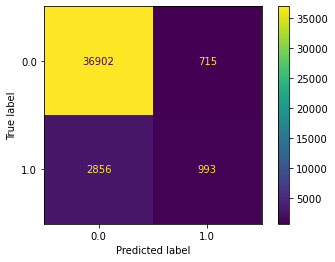

accuracy = 0.9138812521101626
f1 score = 0.35738707935936664
precision = 0.5813817330210773
recall = 0.2579890880748246


In [ ]:
# %%timeit -n1 -r1
#neighbours = 3
neigh = KNeighborsClassifier(n_neighbors=15)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=neigh.classes_)
disp.plot()
plt.show()

asr = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f'accuracy = {asr}')
print(f'f1 score = {f1}')
print (f'precision = {precision}')
print(f'recall = {recall}')
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

In [ ]:
auc(fpr, tpr)

0.6194908621914383

# SMOTE-NC Resampling

In [ ]:
#pre-process data again
weather_full=pd.read_csv("../Data/weather_data_2.csv")

weather_full.timestamp=pd.to_datetime(weather_full.timestamp,infer_datetime_format=True)
weather_full["year"]=weather_full.timestamp.apply(lambda x: x.year)
weather_full["quarter"]=weather_full.timestamp.apply(lambda x: x.quarter)
weather_full["month"]=weather_full.timestamp.apply(lambda x: x.month)
weather_full["day"]=weather_full.timestamp.apply(lambda x: x.day)
weather_full["hour"]=weather_full.timestamp.apply(lambda x: x.hour)

weather_full=pd.concat([weather_full.iloc[:,12:],weather_full.iloc[:,:11],weather_full.iloc[:,11:12]],axis=1)

runtimes=list(pd.date_range('2017-01-01 00:00:00',
                            '2021-12-31 23:59:59',
                            freq='60T'))
training_runtimes=runtimes[:int(0.8*len(runtimes))]
X_train = weather_full[weather_full["timestamp"].isin(training_runtimes)].iloc[:,:-1]
X_test = weather_full[~weather_full["timestamp"].isin(training_runtimes)].iloc[:,:-1]
y_train = weather_full[weather_full["timestamp"].isin(training_runtimes)][["rainfall"]]
y_test = weather_full[~weather_full["timestamp"].isin(training_runtimes)][["rainfall"]]
X_train=X_train.drop(columns=["timestamp"])
X_test=X_test.drop(columns=["timestamp"])

#SMOTE-NC resampling
print(Counter(y_train.rainfall))
smote_nc = SMOTENC(categorical_features=[5], random_state=0)
X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train.rainfall)
Counter(y_resampled)

Counter({0.0: 143549, 1.0: 12625})


Counter({0.0: 143549, 1.0: 143549})

In [ ]:
X_resampled

,year,quarter,month,day,hour,region,past_temperature,past_humidity,past_rainfall,past_wind_x,past_wind_y,delta_temperature,delta_humidity,delta_wind_x,delta_wind_y
0,2017,1,1,1,3,central,26.850000,90.300000,0.000000,-6.000000,-4.000000,-0.100000,-1.421085e-14,0.000000,0.000000
1,2017,1,1,1,3,east,26.125000,87.433333,0.000000,-1.000000,1.000000,-0.150000,-5.333333e-01,0.000000,1.000000
2,2017,1,1,1,3,north,26.000000,87.000000,0.000000,-1.000000,2.000000,-0.100000,4.000000e-01,0.000000,0.000000
3,2017,1,1,1,3,north-east,26.000000,89.250000,0.000000,-1.000000,1.000000,0.033333,-1.500000e-01,-2.000000,-1.000000
4,2017,1,1,1,3,west,26.100000,87.066667,0.000000,-4.000000,0.000000,-0.140000,8.666667e-01,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287093,2018,2,6,6,10,north-east,26.018087,93.458274,0.713579,2.286421,-2.286421,-1.694997,8.821806e+00,0.000000,-3.286421
287094,2017,2,6,18,9,west,28.372432,82.265984,0.000000,-5.108495,-3.108495,-0.204401,2.121119e+00,-3.847491,-1.261004
287095,2017,1,1,2,14,central,26.551796,81.207136,1.000000,6.657089,-0.328545,-0.309497,-1.882089e+00,7.342911,4.000000
287096,2019,2,6,3,19,east,28.960638,81.380277,1.000000,-4.852709,-1.803612,-2.009128,9.654007e+00,-0.901806,0.049097


In [ ]:
temp_df=pd.concat([X_resampled,X_test],axis=0)
temp_df=pd.get_dummies(temp_df, columns=["region"], prefix=["region"])
scaler=StandardScaler()
temp_df.iloc[:,5:14]=scaler.fit_transform(temp_df.iloc[:,5:14])
X_resampled = temp_df.iloc[:len(X_resampled),:]
X_resampled

,year,quarter,month,day,hour,past_temperature,past_humidity,past_rainfall,past_wind_x,past_wind_y,delta_temperature,delta_humidity,delta_wind_x,delta_wind_y,region_central,region_east,region_north,region_north-east,region_west
0,2017,1,1,1,3,-0.368775,0.785725,-0.619154,-1.927747,-0.908897,0.076037,-0.151417,0.016280,0.017967,1,0,0,0,0
1,2017,1,1,1,3,-0.693481,0.525594,-0.619154,-0.405321,0.536957,0.025337,-0.258075,0.016280,0.354667,0,1,0,0,0
2,2017,1,1,1,3,-0.749465,0.486272,-0.619154,-0.405321,0.826128,0.076037,-0.071423,0.016280,0.017967,0,0,1,0,0
3,2017,1,1,1,3,-0.749465,0.690445,-0.619154,-0.405321,0.536957,0.211238,-0.181414,-0.730024,-0.318733,0,0,0,1,0
4,2017,1,1,1,3,-0.704678,0.492322,-0.619154,-1.318777,0.247786,0.035477,0.021903,0.016280,0.017967,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287093,2018,2,6,6,10,-0.741365,1.072317,1.108104,0.595346,-0.413380,-1.541297,1.612804,0.016280,-1.088571,0,0,0,1,0
287094,2017,2,6,18,9,0.313078,0.056692,-0.619154,-1.656297,-0.651100,-0.029826,0.272773,-1.419418,-0.406613,0,0,0,0,1
287095,2017,1,1,2,14,-0.502332,-0.039392,1.801403,1.926150,0.152781,-0.136394,-0.527804,2.756299,1.364767,1,0,0,0,0
287096,2019,2,6,3,19,0.576518,-0.023680,1.801403,-1.578414,-0.273766,-1.859828,1.779230,-0.320231,0.034498,0,1,0,0,0


In [ ]:
X_test = temp_df.iloc[len(X_resampled):,:]
del temp_df
X_test

,year,quarter,month,day,hour,past_temperature,past_humidity,past_rainfall,past_wind_x,past_wind_y,delta_temperature,delta_humidity,delta_wind_x,delta_wind_y,region_central,region_east,region_north,region_north-east,region_west
156174,2020,4,12,31,19,-1.448144,1.300693,1.801403,0.812620,-0.041385,-1.363849,1.083485,1.135735,0.017967,1,0,0,0,0
156175,2020,4,12,31,19,0.370212,-0.838581,-0.619154,1.726076,1.982812,-0.633766,1.088484,1.135735,0.354667,0,1,0,0,0
156176,2020,4,12,31,19,-1.040581,0.658684,1.801403,0.812620,0.247786,-0.126764,0.968494,2.255190,-0.992133,0,0,1,0,0
156177,2020,4,12,31,19,-0.674820,0.519545,1.801403,0.203650,-0.619726,-2.019573,2.361716,-1.103175,-0.655433,0,0,0,1,0
156178,2020,4,12,31,19,-1.436201,1.157773,1.801403,1.117105,0.826128,-0.363365,-0.058091,1.135735,2.711566,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197635,2021,4,12,31,23,-1.794498,1.248516,1.801403,-0.405321,-0.041385,-0.599966,-0.581382,-1.103175,0.354667,1,0,0,0,0
197636,2021,4,12,31,23,-1.286911,1.030732,1.801403,-1.014291,0.247786,0.278838,-0.211412,-0.730024,-0.655433,0,1,0,0,0
197637,2021,4,12,31,23,-1.421272,1.321111,1.801403,-0.100836,-0.041385,0.380239,-0.271407,-0.730024,-0.318733,0,0,1,0,0
197638,2021,4,12,31,23,-1.510846,0.998972,-0.619154,-0.100836,-0.041385,0.532340,-0.351401,0.016280,-0.992133,0,0,0,1,0


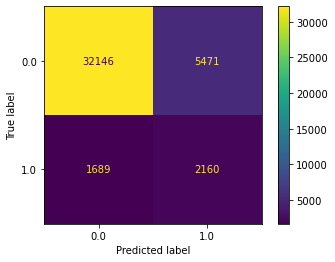

accuracy = 0.8273284136400907
f1 score = 0.37630662020905925
precision = 0.2830559559690735
recall = 0.5611847233047544


In [ ]:
neigh = KNeighborsClassifier(n_neighbors=15)
neigh.fit(X_resampled, y_resampled)
y_pred = neigh.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=neigh.classes_)
disp.plot()
plt.show()

asr = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f'accuracy = {asr}')
print(f'f1 score = {f1}')
print (f'precision = {precision}')
print(f'recall = {recall}')

fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

In [ ]:
auc(fpr, tpr)

0.7078725807022749

# EEN resampling

In [ ]:
from imblearn.under_sampling import EditedNearestNeighbours

#pre-process data again
weather_full=pd.read_csv("../Data/weather_data_2.csv")

weather_full.timestamp=pd.to_datetime(weather_full.timestamp,infer_datetime_format=True)
weather_full["year"]=weather_full.timestamp.apply(lambda x: x.year)
weather_full["quarter"]=weather_full.timestamp.apply(lambda x: x.quarter)
weather_full["month"]=weather_full.timestamp.apply(lambda x: x.month)
weather_full["day"]=weather_full.timestamp.apply(lambda x: x.day)
weather_full["hour"]=weather_full.timestamp.apply(lambda x: x.hour)

weather_full=pd.concat([weather_full.iloc[:,12:],weather_full.iloc[:,:11],weather_full.iloc[:,11:12]],axis=1)

runtimes=list(pd.date_range('2017-01-01 00:00:00',
                            '2021-12-31 23:59:59',
                            freq='60T'))
training_runtimes=runtimes[:int(0.8*len(runtimes))]
X_train = weather_full[weather_full["timestamp"].isin(training_runtimes)].iloc[:,:-1]
X_test = weather_full[~weather_full["timestamp"].isin(training_runtimes)].iloc[:,:-1]
y_train = weather_full[weather_full["timestamp"].isin(training_runtimes)][["rainfall"]]
y_test = weather_full[~weather_full["timestamp"].isin(training_runtimes)][["rainfall"]]
X_train=X_train.drop(columns=["timestamp"])
X_test=X_test.drop(columns=["timestamp"])

temp_df=pd.concat([X_train,X_test],axis=0)
temp_df=pd.get_dummies(temp_df, columns=["region"], prefix=["region"])
X_train = temp_df.iloc[:len(X_train),:]
X_test = temp_df.iloc[len(X_train):,:]
del temp_df

#EEN resampling
print(Counter(y_train.rainfall))
enn = EditedNearestNeighbours()
X_resampled, y_resampled = enn.fit_resample(X_train, y_train.rainfall)
Counter(y_resampled)

Counter({0.0: 143549, 1.0: 12625})


Counter({0.0: 125276, 1.0: 12625})

In [ ]:
temp_df=pd.concat([X_resampled,X_test],axis=0)
scaler=StandardScaler()
temp_df.iloc[:,5:14]=scaler.fit_transform(temp_df.iloc[:,5:14])
X_resampled = temp_df.iloc[:len(X_resampled),:]
X_test = temp_df.iloc[len(X_resampled):,:]
del temp_df

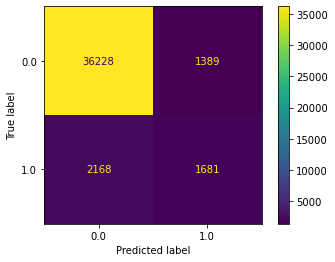

accuracy = 0.9142188781170115
f1 score = 0.4859083682613095
precision = 0.547557003257329
recall = 0.43673681475707976


In [ ]:
neigh = KNeighborsClassifier(n_neighbors=15)
neigh.fit(X_resampled, y_resampled)
y_pred = neigh.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=neigh.classes_)
disp.plot()
plt.show()

asr = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f'accuracy = {asr}')
print(f'f1 score = {f1}')
print (f'precision = {precision}')
print(f'recall = {recall}')

fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

In [ ]:
auc(fpr, tpr)

0.6999060100581794

# SMOTE-ENN resampling

In [ ]:
from imblearn.combine import SMOTEENN

#pre-process data again
weather_full=pd.read_csv("../Data/weather_data_2.csv")

weather_full.timestamp=pd.to_datetime(weather_full.timestamp,infer_datetime_format=True)
weather_full["year"]=weather_full.timestamp.apply(lambda x: x.year)
weather_full["quarter"]=weather_full.timestamp.apply(lambda x: x.quarter)
weather_full["month"]=weather_full.timestamp.apply(lambda x: x.month)
weather_full["day"]=weather_full.timestamp.apply(lambda x: x.day)
weather_full["hour"]=weather_full.timestamp.apply(lambda x: x.hour)

weather_full=pd.concat([weather_full.iloc[:,12:],weather_full.iloc[:,:11],weather_full.iloc[:,11:12]],axis=1)

runtimes=list(pd.date_range('2017-01-01 00:00:00',
                            '2021-12-31 23:59:59',
                            freq='60T'))
training_runtimes=runtimes[:int(0.8*len(runtimes))]
X_train = weather_full[weather_full["timestamp"].isin(training_runtimes)].iloc[:,:-1]
X_test = weather_full[~weather_full["timestamp"].isin(training_runtimes)].iloc[:,:-1]
y_train = weather_full[weather_full["timestamp"].isin(training_runtimes)][["rainfall"]]
y_test = weather_full[~weather_full["timestamp"].isin(training_runtimes)][["rainfall"]]
X_train=X_train.drop(columns=["timestamp"])
X_test=X_test.drop(columns=["timestamp"])

temp_df=pd.concat([X_train,X_test],axis=0)
temp_df=pd.get_dummies(temp_df, columns=["region"], prefix=["region"])
X_train = temp_df.iloc[:len(X_train),:]
X_test = temp_df.iloc[len(X_train):,:]
del temp_df

#SMOTE-EEN resampling
print(Counter(y_train.rainfall))
smoteenn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smoteenn.fit_resample(X_train, y_train.rainfall)
Counter(y_resampled)

Counter({0.0: 143549, 1.0: 12625})


Counter({0.0: 109258, 1.0: 142925})

In [ ]:
temp_df=pd.concat([X_resampled,X_test],axis=0)
scaler=StandardScaler()
temp_df.iloc[:,5:14]=scaler.fit_transform(temp_df.iloc[:,5:14])
X_resampled = temp_df.iloc[:len(X_resampled),:]
X_test = temp_df.iloc[len(X_resampled):,:]
del temp_df

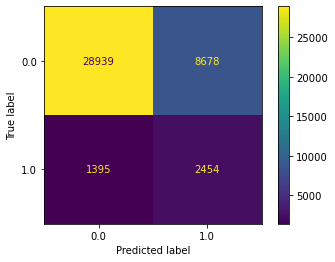

accuracy = 0.7570780880721555
f1 score = 0.3276149789733663
precision = 0.22044556234279555
recall = 0.6375681995323461


In [ ]:
neigh = KNeighborsClassifier(n_neighbors=15)
neigh.fit(X_resampled, y_resampled)
y_pred = neigh.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=neigh.classes_)
disp.plot()
plt.show()

asr = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f'accuracy = {asr}')
print(f'f1 score = {f1}')
print (f'precision = {precision}')
print(f'recall = {recall}')

fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

In [ ]:
auc(fpr, tpr)

0.7034373150677654

# EEN + PCA

Since resampling method of EEN produced the best results, see if PCA helps

In [ ]:
#pre-process data again
weather_full=pd.read_csv("../Data/weather_data_2.csv")

weather_full.timestamp=pd.to_datetime(weather_full.timestamp,infer_datetime_format=True)
weather_full["year"]=weather_full.timestamp.apply(lambda x: x.year)
weather_full["quarter"]=weather_full.timestamp.apply(lambda x: x.quarter)
weather_full["month"]=weather_full.timestamp.apply(lambda x: x.month)
weather_full["day"]=weather_full.timestamp.apply(lambda x: x.day)
weather_full["hour"]=weather_full.timestamp.apply(lambda x: x.hour)

weather_full=pd.concat([weather_full.iloc[:,12:],weather_full.iloc[:,:11],weather_full.iloc[:,11:12]],axis=1)

runtimes=list(pd.date_range('2017-01-01 00:00:00',
                            '2021-12-31 23:59:59',
                            freq='60T'))
training_runtimes=runtimes[:int(0.8*len(runtimes))]
X_train = weather_full[weather_full["timestamp"].isin(training_runtimes)].iloc[:,:-1]
X_test = weather_full[~weather_full["timestamp"].isin(training_runtimes)].iloc[:,:-1]
y_train = weather_full[weather_full["timestamp"].isin(training_runtimes)][["rainfall"]]
y_test = weather_full[~weather_full["timestamp"].isin(training_runtimes)][["rainfall"]]
X_train=X_train.drop(columns=["timestamp"])
X_test=X_test.drop(columns=["timestamp"])

temp_df=pd.concat([X_train,X_test],axis=0)
temp_df=pd.get_dummies(temp_df, columns=["region"], prefix=["region"])
X_train = temp_df.iloc[:len(X_train),:]
X_test = temp_df.iloc[len(X_train):,:]
del temp_df

#EEN resampling
print(Counter(y_train.rainfall))
enn = EditedNearestNeighbours()
X_resampled, y_resampled = enn.fit_resample(X_train, y_train.rainfall)
Counter(y_resampled)

Counter({0.0: 143549, 1.0: 12625})


Counter({0.0: 125276, 1.0: 12625})

In [ ]:
temp_df=pd.concat([X_resampled,X_test],axis=0)
scaler=StandardScaler()
temp_df.iloc[:,5:14]=scaler.fit_transform(temp_df.iloc[:,5:14])
X_resampled = temp_df.iloc[:len(X_resampled),:]
X_test = temp_df.iloc[len(X_resampled):,:]
del temp_df

In [ ]:
temp_df=pd.concat([X_resampled,X_test],axis=0)
pca=PCA(n_components=0.95)
pca_components=pca.fit_transform(temp_df)
pca_df = pd.DataFrame(pca_components,columns=["PC1","PC2","PC3","PC4","PC5"])
pca_df

,PC1,PC2,PC3,PC4,PC5
0,-14.752786,-8.587355,5.605707,0.008591,2.190804
1,-14.752461,-8.590028,5.623165,0.114076,2.181205
2,-14.752317,-8.609680,5.599789,0.001280,2.266561
3,-14.752641,-8.586670,5.535768,0.122659,2.419924
4,-14.757660,-7.589333,5.708197,1.066267,1.757462
...,...,...,...,...,...
179362,15.251609,11.516412,-5.379172,3.687578,-1.121169
179363,15.250172,11.541776,-5.393007,3.000187,-1.245319
179364,15.251093,11.522590,-5.361530,3.037295,-1.291370
179365,15.250855,11.500608,-5.331171,1.477398,-1.635969


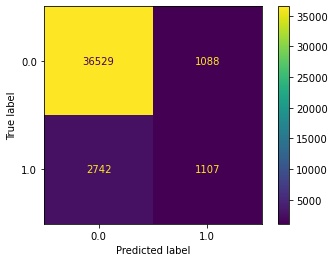

accuracy = 0.9076351709834564
f1 score = 0.36631369953673065
precision = 0.5043280182232346
recall = 0.2876071706936867


In [ ]:

neigh = KNeighborsClassifier(n_neighbors=15)
neigh.fit(pca_df.iloc[:len(X_resampled),:], y_resampled)
y_pred = neigh.predict(pca_df.iloc[len(X_resampled):,:])

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=neigh.classes_)
disp.plot()
plt.show()

asr = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f'accuracy = {asr}')
print(f'f1 score = {f1}')
print (f'precision = {precision}')
print(f'recall = {recall}')
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

In [ ]:
auc(fpr, tpr)

0.629342038705697

# EEN + Hypertuned k-NN

In [ ]:
#pre-process data again
weather_full=pd.read_csv("../Data/weather_data_2.csv")

weather_full.timestamp=pd.to_datetime(weather_full.timestamp,infer_datetime_format=True)
weather_full["year"]=weather_full.timestamp.apply(lambda x: x.year)
weather_full["quarter"]=weather_full.timestamp.apply(lambda x: x.quarter)
weather_full["month"]=weather_full.timestamp.apply(lambda x: x.month)
weather_full["day"]=weather_full.timestamp.apply(lambda x: x.day)
weather_full["hour"]=weather_full.timestamp.apply(lambda x: x.hour)

weather_full=pd.concat([weather_full.iloc[:,12:],weather_full.iloc[:,:11],weather_full.iloc[:,11:12]],axis=1)

runtimes=list(pd.date_range('2017-01-01 00:00:00',
                            '2021-12-31 23:59:59',
                            freq='60T'))
training_runtimes=runtimes[:int(0.8*len(runtimes))]
X_train = weather_full[weather_full["timestamp"].isin(training_runtimes)].iloc[:,:-1]
X_test = weather_full[~weather_full["timestamp"].isin(training_runtimes)].iloc[:,:-1]
y_train = weather_full[weather_full["timestamp"].isin(training_runtimes)][["rainfall"]]
y_test = weather_full[~weather_full["timestamp"].isin(training_runtimes)][["rainfall"]]
X_train=X_train.drop(columns=["timestamp"])
X_test=X_test.drop(columns=["timestamp"])

temp_df=pd.concat([X_train,X_test],axis=0)
temp_df=pd.get_dummies(temp_df, columns=["region"], prefix=["region"])
X_train = temp_df.iloc[:len(X_train),:]
X_test = temp_df.iloc[len(X_train):,:]
del temp_df

#EEN resampling
print(Counter(y_train.rainfall))
enn = EditedNearestNeighbours()
X_resampled, y_resampled = enn.fit_resample(X_train, y_train.rainfall)
Counter(y_resampled)

Counter({0.0: 143549, 1.0: 12625})


Counter({0.0: 125276, 1.0: 12625})

In [ ]:
temp_df=pd.concat([X_resampled,X_test],axis=0)
scaler=StandardScaler()
temp_df.iloc[:,5:14]=scaler.fit_transform(temp_df.iloc[:,5:14])
X_resampled = temp_df.iloc[:len(X_resampled),:]
X_test = temp_df.iloc[len(X_resampled):,:]
del temp_df

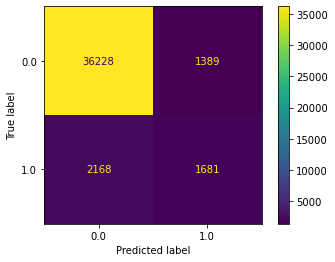

accuracy = 0.9142188781170115
f1 score = 0.4859083682613095
precision = 0.547557003257329
recall = 0.43673681475707976


In [ ]:
neigh = KNeighborsClassifier(n_neighbors=15, algorithm='ball_tree', weights='uniform', metric='euclidean', leaf_size=20)
neigh.fit(X_resampled, y_resampled)
y_pred = neigh.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=neigh.classes_)
disp.plot()
plt.show()

asr = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f'accuracy = {asr}')
print(f'f1 score = {f1}')
print (f'precision = {precision}')
print(f'recall = {recall}')

fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

In [ ]:
auc(fpr, tpr)

0.6999060100581794

In [ ]:
from sklearn.model_selection import GridSearchCV


In [ ]:
# knn = KNeighborsClassifier(algorithm='kd_tree', weights='distance', n_neighbors=15)
knn = KNeighborsClassifier(n_neighbors=15, algorithm='ball_tree', weights='uniform', metric='euclidean')


parameters= { 'leaf_size':[20, 21]}


clf = GridSearchCV(knn, parameters)
clf.fit(X_resampled,y_resampled)

GridSearchCV(estimator=KNeighborsClassifier(algorithm='ball_tree',
                                            metric='euclidean',
                                            n_neighbors=15),
             param_grid={'leaf_size': [20, 21]})

In [ ]:
print (clf.best_params_)

{'leaf_size': 20}
